# Hybrid Model for Diabetic Retinopathy Diagnosis & Classification

This notebook focuses on developing a **hybrid deep learning model** to diagnose and classify **diabetic retinopathy (DR) stages** from retinal images.

# 📂 Downloading & Accessing Diabetic Retinopathy Dataset

This cell **downloads the dataset** from **Kaggle** and sets up the directory for accessing images.

In [ ]:
import kagglehub
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt


dataset_path = kagglehub.dataset_download("tanlikesmath/diabetic-retinopathy-resized")
print("Path to dataset files:", dataset_path)


100%|██████████| 7.25G/7.25G [06:37<00:00, 19.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7


This cell **sets up the dataset path**, **reads image labels**, and **displays sample images** to ensure correct data loading before preprocessing.


Contents of resized_train: ['resized_train']
Updated Images Path: /root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7/resized_train/resized_train
Sample images in resized_train: ['36036_right.jpeg', '2830_left.jpeg', '15507_right.jpeg', '42505_right.jpeg', '38919_right.jpeg', '13013_right.jpeg', '35987_left.jpeg', '24518_left.jpeg', '10622_left.jpeg', '43903_left.jpeg']


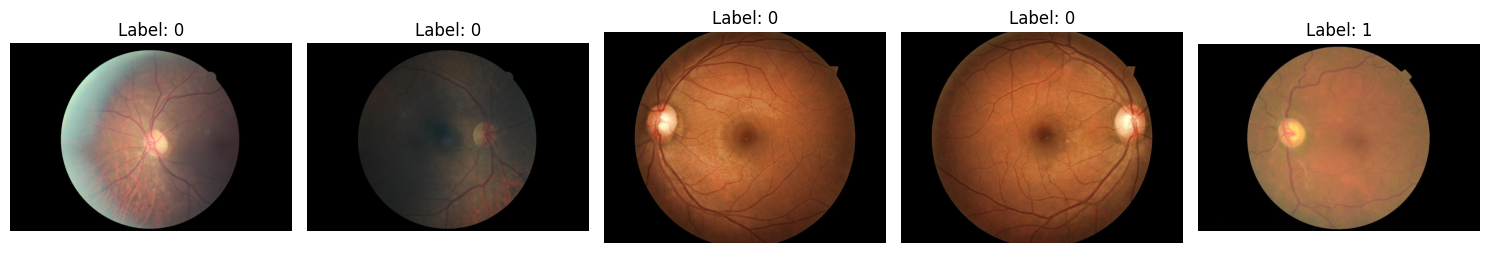

In [ ]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


dataset_path = "/root/.cache/kagglehub/datasets/tanlikesmath/diabetic-retinopathy-resized/versions/7"
images_path = os.path.join(dataset_path, "resized_train")
labels_file = os.path.join(dataset_path, "trainLabels.csv")


print("Contents of resized_train:", os.listdir(images_path))


if len(os.listdir(images_path)) == 1 and os.path.isdir(os.path.join(images_path, os.listdir(images_path)[0])):
    images_path = os.path.join(images_path, os.listdir(images_path)[0])
    print("Updated Images Path:", images_path)


print("Sample images in resized_train:", os.listdir(images_path)[:10])

labels_df = pd.read_csv(labels_file)

def display_images_with_labels(labels_df, images_path, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        if i >= len(labels_df):
            break
        row = labels_df.iloc[i]
        image_name = row['image'] + ".jpeg"
        label = row['level']
        image_path = os.path.join(images_path, image_name)

        if os.path.exists(image_path):
            image = Image.open(image_path)
            ax.imshow(image)
            ax.set_title(f"Label: {label}")
            ax.axis('off')
        else:
            print(f"Image not found: {image_name}")
            ax.set_title(f"Image not found")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

display_images_with_labels(labels_df, images_path, num_images=5)

# 📊 Analyzing Label Distribution

This cell **analyzes the distribution of diabetic retinopathy labels** in the dataset to ensure a balanced representation before training the model.

Label distribution:
level
0    25810
2     5292
1     2443
3      873
4      708
Name: count, dtype: int64


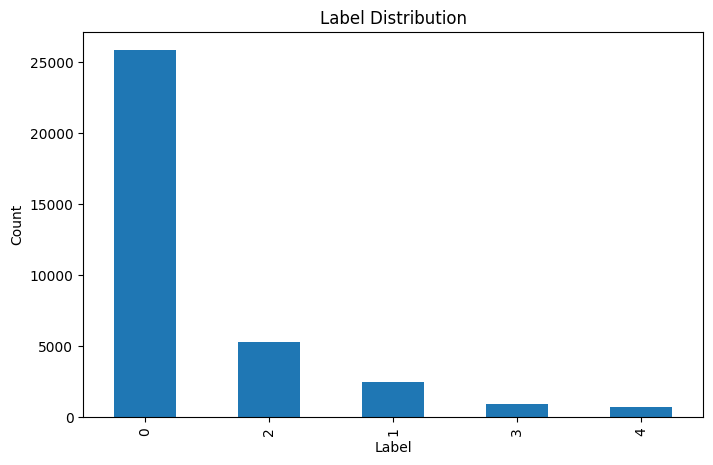

In [ ]:
print("Label distribution:")
label_counts = labels_df['level'].value_counts()
print(label_counts)


label_counts.plot(kind='bar', figsize=(8, 5), title="Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Balancing the Dataset Using Resampling

This cell **balances the dataset** by **upsampling minority classes**, ensuring fair representation of all diabetic retinopathy stages.


New label distribution:
level
0    25810
1     5000
2     5000
3     4000
4     4000
Name: count, dtype: int64


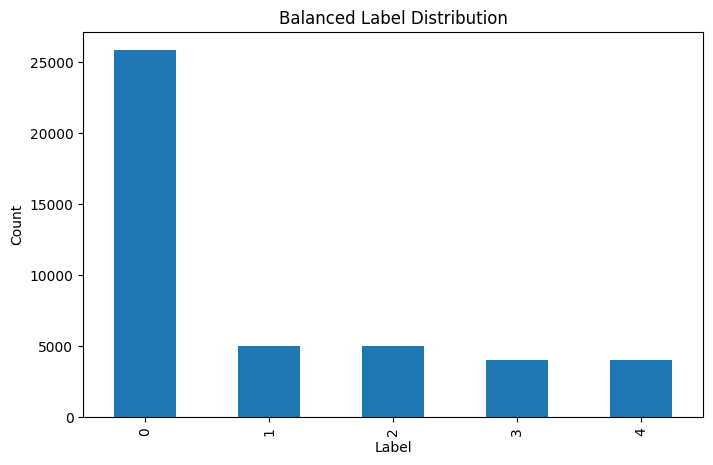

In [ ]:
from sklearn.utils import resample


df_majority = labels_df[labels_df['level'] == 0]
df_minority_1 = labels_df[labels_df['level'] == 1]
df_minority_2 = labels_df[labels_df['level'] == 2]
df_minority_3 = labels_df[labels_df['level'] == 3]
df_minority_4 = labels_df[labels_df['level'] == 4]


df_minority_1_upsampled = resample(df_minority_1, replace=True, n_samples=5000, random_state=42)
df_minority_2_upsampled = resample(df_minority_2, replace=True, n_samples=5000, random_state=42)
df_minority_3_upsampled = resample(df_minority_3, replace=True, n_samples=4000, random_state=42)
df_minority_4_upsampled = resample(df_minority_4, replace=True, n_samples=4000, random_state=42)


balanced_df = pd.concat([df_majority, df_minority_1_upsampled, df_minority_2_upsampled, df_minority_3_upsampled, df_minority_4_upsampled])


print("New label distribution:")
print(balanced_df['level'].value_counts())


balanced_df['level'].value_counts().plot(kind='bar', figsize=(8, 5), title="Balanced Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Adaptive Contrast Enhancement (ACE) for Image Preprocessing

This cell applies **Adaptive Contrast Enhancement (ACE)** to **improve image visibility** and **highlight retinal features**, helping the deep learning model learn more distinguishable patterns.

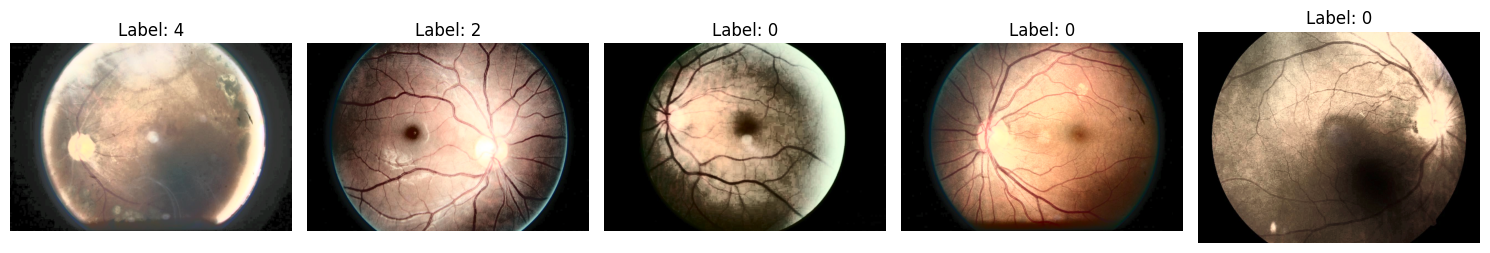

In [ ]:
import cv2
import numpy as np
from PIL import Image


def apply_ace(image):
    image_array = np.array(image)
    if len(image_array.shape) == 3 and image_array.shape[2] == 3:
        lab_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab_image)


        l = cv2.equalizeHist(l)


        enhanced_lab = cv2.merge((l, a, b))
        enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    else:
        enhanced_image = cv2.equalizeHist(image_array)
    return Image.fromarray(enhanced_image)


def display_images_with_ace(labels_df, images_path, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    sampled_rows = labels_df.sample(n=num_images)
    for i, (index, row) in enumerate(sampled_rows.iterrows()):
        image_name = row['image'] + ".jpeg"
        image_path = os.path.join(images_path, image_name)

        if os.path.exists(image_path):
            image = Image.open(image_path)
            enhanced_image = apply_ace(image)
            axes[i].imshow(enhanced_image)
            axes[i].set_title(f"Label: {row['level']}")
            axes[i].axis('off')
        else:
            print(f"Image not found: {image_name}")
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()

display_images_with_ace(balanced_df, images_path, num_images=5)

#  Data Augmentation with Adaptive Contrast Enhancement (ACE)

This cell **applies image augmentation combined with Adaptive Contrast Enhancement (ACE)** to further balance the dataset and improve model robustness.

New label distribution after Augmentation with ACE:
level
0    25810
1    12000
2    12000
3    10000
4    10000
Name: count, dtype: int64


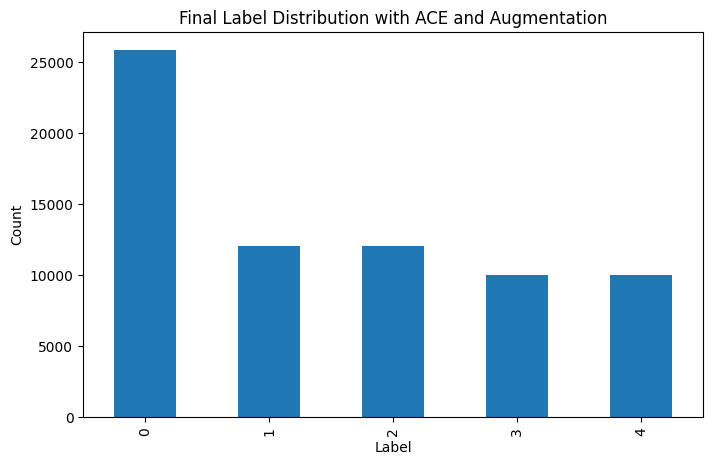

In [ ]:
import cv2
from PIL import Image
import numpy as np
from imgaug import augmenters as iaa


augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-20, 20)),
    iaa.AdditiveGaussianNoise(scale=(10, 20)),
    iaa.Multiply((0.8, 1.2))
])


def apply_ace(image):
    image_array = np.array(image)
    if len(image_array.shape) == 3 and image_array.shape[2] == 3:
        lab_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab_image)


        l = cv2.equalizeHist(l)


        enhanced_lab = cv2.merge((l, a, b))
        enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
    else:
        enhanced_image = cv2.equalizeHist(image_array)
    return Image.fromarray(enhanced_image)


def augment_image_with_ace(image_path, augmentor):
    image = Image.open(image_path).convert('RGB')


    enhanced_image = apply_ace(image)


    image_array = np.array(enhanced_image)
    augmented_image = augmentor(image=image_array)
    return Image.fromarray(augmented_image)


def augment_class_with_ace(dataframe, class_label, target_size, images_path):
    class_df = dataframe[dataframe['level'] == class_label]
    augmented_data = []
    augmented_count = 0

    for _, row in class_df.iterrows():
        image_name = row['image'] + ".jpeg"
        image_path = os.path.join(images_path, image_name)

        if os.path.exists(image_path):
            while augmented_count < target_size:
                augmented_image = augment_image_with_ace(image_path, augmentation)
                new_image_name = f"{row['image']}_aug_ace_{augmented_count}"
                augmented_image_path = os.path.join(images_path, f"{new_image_name}.jpeg")


                augmented_image.save(augmented_image_path)


                augmented_data.append({'image': new_image_name, 'level': class_label})
                augmented_count += 1


    return pd.DataFrame(augmented_data)


augmented_1 = augment_class_with_ace(balanced_df, class_label=1, target_size=7000, images_path=images_path)
augmented_2 = augment_class_with_ace(balanced_df, class_label=2, target_size=7000, images_path=images_path)
augmented_3 = augment_class_with_ace(balanced_df, class_label=3, target_size=6000, images_path=images_path)
augmented_4 = augment_class_with_ace(balanced_df, class_label=4, target_size=6000, images_path=images_path)


final_augmented_df_with_ace = pd.concat([balanced_df, augmented_1, augmented_2, augmented_3, augmented_4], ignore_index=True)


print("New label distribution after Augmentation with ACE:")
print(final_augmented_df_with_ace['level'].value_counts())


final_augmented_df_with_ace['level'].value_counts().plot(kind='bar', figsize=(8, 5), title="Final Label Distribution with ACE and Augmentation")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# 📂 Splitting Dataset into Training, Validation, and Test Sets

This cell **splits the final augmented dataset** into **training, validation, and test sets** while ensuring a **stratified distribution of labels**.

In [ ]:
from sklearn.model_selection import train_test_split


train_df, temp_df = train_test_split(final_augmented_df_with_ace, test_size=0.3, stratify=final_augmented_df_with_ace['level'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['level'], random_state=42)


print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


print("\nTraining set distribution:")
print(train_df['level'].value_counts())
print("\nValidation set distribution:")
print(val_df['level'].value_counts())
print("\nTest set distribution:")
print(test_df['level'].value_counts())

Training set size: 48867
Validation set size: 10471
Test set size: 10472

Training set distribution:
level
0    18067
2     8400
1     8400
4     7000
3     7000
Name: count, dtype: int64

Validation set distribution:
level
0    3871
2    1800
1    1800
3    1500
4    1500
Name: count, dtype: int64

Test set distribution:
level
0    3872
2    1800
1    1800
4    1500
3    1500
Name: count, dtype: int64


# 📂 Preparing Dataset for PyTorch Training

This cell **creates a PyTorch dataset and data loaders** to efficiently handle the diabetic retinopathy dataset during training, validation, and testing.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class RetinopathyDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe
        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_name = row['image'] + ".jpeg"
        label = row['level']
        image_path = os.path.join(self.images_path, image_name)

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label


train_dataset = RetinopathyDataset(train_df, images_path, transform=transform)
val_dataset = RetinopathyDataset(val_df, images_path, transform=transform)
test_dataset = RetinopathyDataset(test_df, images_path, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("DataLoaders are ready!")

DataLoaders are ready!


# 🖼️ Visualizing Sample Images from DataLoader

This cell **displays sample images** from the training dataset to verify that images are correctly **loaded, preprocessed, and labeled** before training.

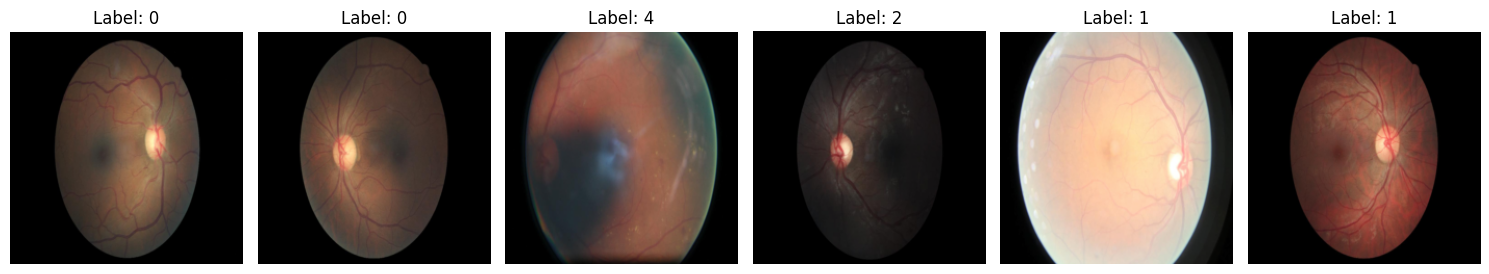

In [ ]:
def show_sample_images(loader, num_images=6):
    images, labels = next(iter(loader))
    images = images[:num_images]
    labels = labels[:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        image = images[i].permute(1, 2, 0).numpy()
        image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        ax.imshow(image)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


show_sample_images(train_loader)

# Hybrid CNN-ViT Model for Diabetic Retinopathy Classification

This cell defines a **hybrid deep learning model** that combines **DenseNet-121 (CNN)** with a **Vision Transformer (ViT)** for improved diabetic retinopathy classification.

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import densenet121
from transformers import ViTModel, ViTConfig

class CNN_ViT_Model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_ViT_Model, self).__init__()

        # DenseNet-121
        self.cnn = densenet121(pretrained=True)
        self.cnn.classifier = nn.Identity()

        # Fine-tuning
        for param in self.cnn.features.parameters():
            param.requires_grad = True

        # Vision Transformer (ViT)
        vit_config = ViTConfig.from_pretrained("google/vit-base-patch16-224", num_labels=num_classes)
        self.vit = ViTModel(vit_config)

        # Fine-tuning
        for param in self.vit.parameters():
            param.requires_grad = True

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(1024 + vit_config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # DenseNet Features
        cnn_features = self.cnn(x)

        # Vision Transformer Features
        vit_features = self.vit(pixel_values=x).pooler_output


        combined_features = torch.cat((cnn_features, vit_features), dim=1)


        output = self.fc(combined_features)
        return output


num_classes = 5

model = CNN_ViT_Model(num_classes)

print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 214MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Huggin

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

CNN_ViT_Model(
  (cnn): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0

# ⚙️ Setting Up Loss Function, Optimizer, and Learning Rate Scheduler


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training & Evaluating the CNN-ViT Model

This cell implements **training and evaluation functions** for the hybrid **CNN-ViT model**, using **PyTorch**. The model is trained on **diabetic retinopathy images**, and its performance is evaluated using multiple metrics.

In [ ]:
import torch
import time
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
)
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def calculate_metrics(y_true, y_pred, probs):
    metrics = {
        "F1": f1_score(y_true, y_pred, average="weighted"),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted"),
        "AUC ROC": roc_auc_score(y_true, probs, multi_class="ovr"),
        "AP": average_precision_score(y_true, probs, average="weighted"),
        "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred),
        "Accuracy": accuracy_score(y_true, y_pred),
    }
    return metrics

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 20)

        model.train()
        running_loss = 0.0
        all_preds, all_labels, all_probs = [], [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

        scheduler.step()

        metrics = calculate_metrics(all_labels, all_preds, np.array(all_probs))
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Train Loss: {epoch_loss:.4f}")
        for metric, value in metrics.items():
            print(f"Train {metric}: {value:.4f}")

        val_loss, val_metrics = evaluate_model(model, val_loader, criterion)
        print(f"Validation Loss: {val_loss:.4f}")
        for metric, value in val_metrics.items():
            print(f"Validation {metric}: {value:.4f}")

        if val_metrics["Accuracy"] > best_val_acc:
            best_val_acc = val_metrics["Accuracy"]
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

    loss = running_loss / len(loader.dataset)
    metrics = calculate_metrics(all_labels, all_preds, np.array(all_probs))
    return loss, metrics

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1/10
--------------------
Train Loss: 0.5444
Train F1: 0.8031
Train Precision: 0.8356
Train Recall: 0.8082
Train AUC ROC: 0.9434
Train AP: 0.8504
Train Balanced Accuracy: 0.7750
Train Accuracy: 0.8082
Validation Loss: 0.4502
Validation F1: 0.8285
Validation Precision: 0.8679
Validation Recall: 0.8345
Validation AUC ROC: 0.9607
Validation AP: 0.8906
Validation Balanced Accuracy: 0.8029
Validation Accuracy: 0.8345
Best model saved!
Epoch 2/10
--------------------
Train Loss: 0.3824
Train F1: 0.8564
Train Precision: 0.8691
Train Recall: 0.8603
Train AUC ROC: 0.9686
Train AP: 0.9108
Train Balanced Accuracy: 0.8436
Train Accuracy: 0.8603
Validation Loss: 0.3828
Validation F1: 0.8538
Validation Precision: 0.8580
Validation Recall: 0.8542
Validation AUC ROC: 0.9725
Validation AP: 0.9209
Validation Balanced Accuracy: 0.8637
Validation Accuracy: 0.8542
Best model saved!
Epoch 3/10
--------------------
Train Loss: 0.2726
Train F1: 0.8991
Train Precision: 0.9023
Train Recall: 0.9004
Train A

# Final Model Evaluation on the Test Set

This cell **evaluates the trained CNN-ViT model** on the **test dataset** to measure its final performance and verify its generalization capability.

In [ ]:
import torch
import numpy as np
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
)

def calculate_metrics(y_true, y_pred, probs):
    metrics = {
        "F1": f1_score(y_true, y_pred, average="weighted"),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted"),
        "AUC ROC": roc_auc_score(y_true, probs, multi_class="ovr"),
        "AP": average_precision_score(y_true, probs, average="weighted"),
        "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred),
        "Accuracy": accuracy_score(y_true, y_pred),
    }
    return metrics

def evaluate_test_set(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels, all_probs = [], [], []

    print("Starting evaluation on test set...")

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probs, axis=1)

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)

    if len(all_labels) == 0:
        print(" No test samples processed")

    test_loss = running_loss / len(test_loader.dataset) if len(test_loader.dataset) > 0 else 0
    metrics = calculate_metrics(all_labels, all_preds, np.array(all_probs)) if len(all_labels) > 0 else {}

    print("\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    for metric, value in metrics.items():
        print(f"Test {metric}: {value:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    return test_loss, metrics.get("Accuracy", 0.0)


model.load_state_dict(torch.load("best_model.pth"))
model.to(device)


test_loss, test_acc = evaluate_test_set(model, test_loader, criterion)


print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

<ipython-input-22-03ebe20a075b>:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Starting evaluation on test set...

Test Results:
Test Loss: 0.4229
Test F1: 0.9437
Test Precision: 0.9444
Test Recall: 0.9439
Test AUC ROC: 0.9873
Test AP: 0.9635
Test Balanced Accuracy: 0.9439
Test Accuracy: 0.9439

Confusion Matrix:
[[3709   66   95    0    2]
 [ 150 1642    8    0    0]
 [ 198   16 1559   22    5]
 [   5    1   12 1480    2]
 [   1    0    3    1 1495]]
Test Loss: 0.4229
Test Accuracy: 0.9439
